# Object detection on the customised VRD dataset

### Inference - version 1

This notebook performs **inference** using a trained faster-rcnn-resnet50-fpn object detection model that has been trained on the VRD (visual relationship detection) dataset whose annotations have been heavily customised (quality-improved / de-noised) by Dave Herron. The inference performance of the trained model is then **evaluated** visually.

The ideal evaluation scenario is to separately display the image under analysis with all of its ground-truth annotations (bboxes and object classes) (e.g. in an IDE or other notebook) and to use this notebook to display the same image but with all of the predicted bboxes and object classes detected by the object detector model.

In [1]:
import torch
import torchvision

from vrd_dataset_frcnn import VRDDataset

import json
import os

import PIL
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib import patheffects

In [2]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
print(f'device: {device}')

device: cpu


In [10]:
# Prepare the VRD object class names

# get the VRD object class names 
vrd_objects_file = os.path.join('..', 'data', 'annotations_customised', 'vrd_dh_objects.json')
with open(vrd_objects_file, 'r') as file:
    vrd_object_class_names = json.load(file)

print(f"Nr of VRD object classes (excl. 'background'): {len(vrd_object_class_names)}")    
    
# insert a new 'background' class at index 0
vrd_object_class_names = list(vrd_object_class_names)
vrd_object_class_names.insert(0, '__background__')

# insert class 'clock face' which was there originally in v1 of the model but which 
# we subsequently removed for v2 of the model but only after having already trained 
# v1 of the model
#vrd_object_class_names.insert(112, 'clock face')

vrd_object_class_names = tuple(vrd_object_class_names)

n_vrd_object_classes = len(vrd_object_class_names)

#print('VRD object class names:')
#print(vrd_object_class_names)

# build a dictionary with class names as keys and class indices as values
vrd_object_class_names_to_indices = {}
for idx, name in enumerate(vrd_object_class_names):
    vrd_object_class_names_to_indices[name] = idx

#print()
#print('VRD object class names and indices:')
#print(vrd_object_class_names_to_indices)

# build a dictionary with class indices as keys and class names as values
#vrd_object_class_indices_to_names = {}
#for idx, name in enumerate(vrd_object_class_names):
#    vrd_object_class_indices_to_names[idx] = name

#print()
#print('VRD object class indices and names:')
#print(vrd_object_class_indices_to_names)   
    

Nr of VRD object classes (excl. 'background'): 112


In [51]:
# set the VRD dataset image directory
vrd_img_dir = os.path.join('..', 'data', 'train_images')

print(f'Image dir: {vrd_img_dir}')

# set the VRD image annotations file path
#vrd_anno_file = os.path.join('..', 'data', 'annotations_customised', 
#                             'vrd_dh_annotations_train_testsubset.json')

vrd_anno_file = os.path.join('..', 'data', 'annotations_customised', 
                             'vrd_dh_annotations_train_trainsubset.json')

print(f'Annotations file: {vrd_anno_file}')

# load the annotations for the VRD dataset images for which we are
# about to perform object detection inference
with open(vrd_anno_file, 'r') as file:
    vrd_img_anno = json.load(file)

# extract the image names from the annotations
vrd_img_names = list(vrd_img_anno.keys())

print(f'Number of VRD images to be processed: {len(vrd_img_names)}')


Image dir: ../data/train_images
Annotations file: ../data/annotations_customised/vrd_dh_annotations_train_trainsubset.json
Number of VRD images to be processed: 3000


In [12]:
# Load a pre-trained Faster R-CNN ResNet-50 FPN model

# Definitions of selected model hyper-parameters:
# box_score_thresh : only return proposals with score > thresh (inference only)
# num_classes : nr of object classes (including a 'background' class at index 0)
# rpn_batch_size_per_image : nr anchors sampled during training of the RPN, re RPN loss calc
# box_batch_size_per_image : nr proposals sampled during training of ROI classification head

# Note: the customised VRD dataset has 113 object classes (excluding a 'background' class),
# but we can't increase the number of output classes here if we wish to download and 
# begin with a pre-trained model. So, for now, we keep the number of classes at 91
# (1 'background' class, plus 90 object classes), which is the number of classes against
# which the model was pre-trained.
# 
# Once we've downloaded the pre-trained model, we will adapt its dual output layers to
# fit the number of VRD object classes and then train it on the VRD training set to learn 
# to detect the VRD object classes.

# set model hyper-parameters
model_args = {'box_score_thresh': 0.75,
              'num_classes': 91,
              'rpn_batch_size_per_image': 256,
              'box_batch_size_per_image': 256}

# load the pre-trained model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, **model_args)


In [13]:
# note: the fasterrcnn_resnet50_fpn_coco-258fb6c6.pth checkpoint file is downloaded 
#       to directory: ~/.cache/torch/hub/checkpoints/

# confirm where the downloaded model with pre-trained weights is stored
torch.hub.get_dir()

'/Users/dave/.cache/torch/hub'

## Customise the model for the VRD dataset

In [14]:
# adjust the number of output features in the classification output layer (for the
# object class predictions) to match the number of object classes in the VRD dataset
# (plus 1 for a 'background' class)
model.roi_heads.box_predictor.cls_score.out_features = n_vrd_object_classes

# adjust the number of output features in the regression output layer (for the
# bounding box predictions) to match 4 times the number of object classes in the 
# VRD dataset (plus 1 for a 'background' class)
model.roi_heads.box_predictor.bbox_pred.out_features = n_vrd_object_classes * 4

In [15]:
# replace the classification output layer's weights and biases with new random ones 
# whose dimensions match the layer's revised output size
in_feat = model.roi_heads.box_predictor.cls_score.in_features
out_feat = model.roi_heads.box_predictor.cls_score.out_features
weights = torch.rand(out_feat, in_feat)
model.roi_heads.box_predictor.cls_score.weight = torch.nn.Parameter(weights, requires_grad=True)
biases = torch.rand(out_feat)
model.roi_heads.box_predictor.cls_score.bias = torch.nn.Parameter(biases, requires_grad=True)

# replace the bbox regression output layer's weights and biases with new random ones 
# whose dimensions match the layer's revised output size
in_feat = model.roi_heads.box_predictor.bbox_pred.in_features
out_feat = model.roi_heads.box_predictor.bbox_pred.out_features
weights = torch.rand(out_feat, in_feat)
model.roi_heads.box_predictor.bbox_pred.weight = torch.nn.Parameter(weights, requires_grad=True)
biases = torch.rand(out_feat)
model.roi_heads.box_predictor.bbox_pred.bias = torch.nn.Parameter(biases, requires_grad=True)


In [16]:
print(model)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

## Load trained model from checkpoint file

In [19]:
# function to load trained model checkpoint file

def load_model_checkpoint(checkpoint_path, model):
    
    # load checkpoint file
    model_checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    
    # initialise the model and optimiser state (in-place) to the saved state 
    model.load_state_dict(model_checkpoint['model_state_dict'])
     
    # get other variables saved to the checkpoint file
    epoch = model_checkpoint['epoch']
    avg_loss_per_mb = model_checkpoint['avg_loss_per_mb']
    
    print(f"Model checkpoint file loaded: {checkpoint_path}")
    
    return epoch, avg_loss_per_mb

In [20]:
# load a checkpoint file representing a trained model
checkpoint_path = 'vrd_frcnn_v2_checkpoint_510.pth'
args = {'checkpoint_path': checkpoint_path, 'model': model}
last_epoch, last_avg_loss_per_mb = load_model_checkpoint(**args)
print(f"last epoch: {last_epoch}; last avg loss per mb: {last_avg_loss_per_mb:.4f}")

Model checkpoint file loaded: vrd_frcnn_v2_checkpoint_510.pth
last epoch: 510; last avg loss per mb: 0.1459


## Prepare for inference

In [52]:
# prepare a VRDDataset to load a single VRD example: (idx, img, targets)
dataset_item = VRDDataset(vrd_img_dir=vrd_img_dir, vrd_anno_file=vrd_anno_file)

In [22]:
# push model to GPU if it's available
if device == torch.device('cuda'):
    model = model.to(device)

In [23]:
# put model in evaluation mode
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

## Perform inference

In [24]:
def calc_figure_dimensions(size):
    w, h = size[0], size[1]
    wstr = str(w)
    if len(wstr) == 4:
        w2str = wstr[0:2]
    else:
        w2str = wstr[0]
    w2 = int(w2str)
    hstr = str(h)
    if len(hstr) == 4:
        h2str = hstr[0:2]
    else:
        h2str = hstr[0]
    h2 = int(h2str)
    max_dim = max(w2,h2)
    sf = 12 / max_dim
    w3 = w2 * sf
    h3 = h2 * sf
    return w3, h3

In [25]:
def inference_vrd_frcnn(imgTen, imgPIL):
  
    out = model([imgTen])
    print(out)
    
    scores = out[0]['scores']
    bboxes = out[0]['boxes']
    bboxes = bboxes.detach()   
    classes = out[0]['labels']
    
    if len(scores) == 0:
        print('problem: image has no predictions')
    else:
        fw, fh = calc_figure_dimensions(imgPIL.size)
        plt.figure(figsize=(fw,fh))
        plt.imshow(imgPIL)
        ax = plt.gca()
        for idx, b in enumerate(bboxes):
            anchor = (b[0], b[1])
            width = b[2] - b[0]
            height = b[3] - b[1]
            # TODO: try arg fill=False instead of fc='none'
            rect = patches.Rectangle(anchor, width, height, lw=2, ec='r', fc='none')
            ax.add_patch(rect)
            #ax.text(b[0], (b[1]-5), str(classes[idx].item()), color='green',
            #        fontsize=14, weight='heavy')
            ax.text(b[0], (b[1]-5), str(classes[idx].item()), color='green', fontsize=14,
                    weight='heavy').set_path_effects([patheffects.Stroke(linewidth=2, foreground='black'), patheffects.Normal()])
        plt.show()


In [53]:
# get the image filename based on an index
idx = 0
imname = vrd_img_names[idx]
imname

'4201263073_2b7c090aa6_b.jpg'

In [63]:
# get the image index based on a filename
imname = '947317936_6816fc0426_o.jpg'
idx = vrd_img_names.index(imname)
idx

3

In [64]:
print(f'image name: {imname}') 

# get the image as a Tensor, ready to pass to the model
idx2, img_Tensor, targets = dataset_item[idx]
print(f'Tensor image size (C x H x W): {img_Tensor.size()}')

# for display purposes, also get the image as a PIL image
path = os.path.join(vrd_img_dir, imname)
img_PIL = PIL.Image.open(path)
print(f'PIL image size (W x H): {img_PIL.size}')

image name: 947317936_6816fc0426_o.jpg
Tensor image size (C x H x W): torch.Size([3, 1280, 960])
PIL image size (W x H): (960, 1280)


[{'boxes': tensor([[ 113.5201,    2.4622,  960.0001,  376.8499],
        [ 639.0469,  480.7859,  685.8737,  550.7421],
        [ 451.7036,  723.1431,  749.1444, 1167.9572],
        [   6.8655,   20.8051,  273.5337,  418.3658],
        [ 559.7957,  272.8243,  746.4740,  519.6737],
        [ 494.6922,  713.3448,  844.8178,  967.7941],
        [ 523.2409,  984.0814,  669.3123, 1098.6974],
        [ 252.3734,  244.1030,  448.2854,  469.9674],
        [ 555.7523,  854.6940,  717.9401,  999.9431],
        [ 486.6725,  457.1101,  646.1842,  504.0852],
        [   4.2749,  521.5818,  960.0001, 1245.5526],
        [ 484.5885, 1017.6960,  681.8037, 1113.1108]],
       grad_fn=<StackBackward0>), 'labels': tensor([ 2,  1,  1,  3, 12, 23, 17,  3, 20,  5, 98, 34]), 'scores': tensor([1.0000, 0.9999, 0.9999, 0.9999, 0.9997, 0.9991, 0.9987, 0.9972, 0.9967,
        0.9954, 0.9790, 0.9421], grad_fn=<IndexBackward0>)}]


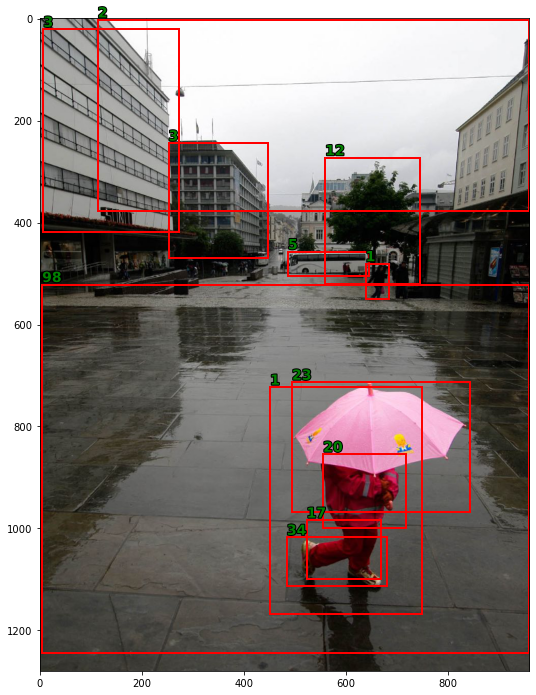

In [65]:
# perform inference on the image;
# and display the detected bboxes and predicted object class labels
inference_vrd_frcnn(img_Tensor, img_PIL)

In [56]:
# print the object class names and indices so we can easily visually convert
# from object class labels to object class names
print('VRD object class names and indices:')
print(vrd_object_class_names_to_indices)

VRD object class names and indices:
{'__background__': 0, 'person': 1, 'sky': 2, 'building': 3, 'truck': 4, 'bus': 5, 'table': 6, 'shirt': 7, 'chair': 8, 'car': 9, 'train': 10, 'glasses': 11, 'tree': 12, 'boat': 13, 'hat': 14, 'trees': 15, 'grass': 16, 'pants': 17, 'road': 18, 'motorcycle': 19, 'jacket': 20, 'monitor': 21, 'wheel': 22, 'umbrella': 23, 'plate': 24, 'bike': 25, 'clock': 26, 'bag': 27, 'shoe': 28, 'laptop': 29, 'desk': 30, 'cabinet': 31, 'counter': 32, 'bench': 33, 'shoes': 34, 'tower': 35, 'bottle': 36, 'helmet': 37, 'stove': 38, 'lamp': 39, 'coat': 40, 'bed': 41, 'dog': 42, 'mountain': 43, 'horse': 44, 'plane': 45, 'roof': 46, 'skateboard': 47, 'traffic light': 48, 'bush': 49, 'phone': 50, 'airplane': 51, 'sofa': 52, 'cup': 53, 'sink': 54, 'shelf': 55, 'box': 56, 'van': 57, 'hand': 58, 'shorts': 59, 'post': 60, 'jeans': 61, 'cat': 62, 'sunglasses': 63, 'bowl': 64, 'computer': 65, 'pillow': 66, 'pizza': 67, 'basket': 68, 'elephant': 69, 'kite': 70, 'sand': 71, 'keyboard'

**Note:** see document 'vrd_frcnn model evaluation.md' for notes regarding qualitative evaluation of models at different stages of training